In [427]:
# Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(color_codes=True)

In [428]:
file_path = 'sensor_data.csv'
sen_data = pd.read_csv(file_path)
print(sen_data.dtypes)
sen_data.head()

datetime      object
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object


,datetime,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,180.544277,371.600611,107.553307,41.467880


In [429]:
print("-----BEFORE-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

# Date convert to timestamp data type
sen_data['datetime'] = pd.to_datetime(sen_data['datetime'])

print("-----AFTER-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

-----BEFORE-----
2015-01-01 06:00:00
<class 'str'>
-----AFTER-----
2015-01-01 06:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [430]:
fail_dt = pd.read_csv('fail_log.csv')
fail_dt.head()

,datetime
0,2/4/2015 6:00
1,3/21/2015 6:00
2,4/5/2015 6:00
3,5/5/2015 6:00
4,5/20/2015 6:00


In [431]:
fail_dt['datetime'] = pd.to_datetime(fail_dt['datetime']) # Date convert to timestamp data type

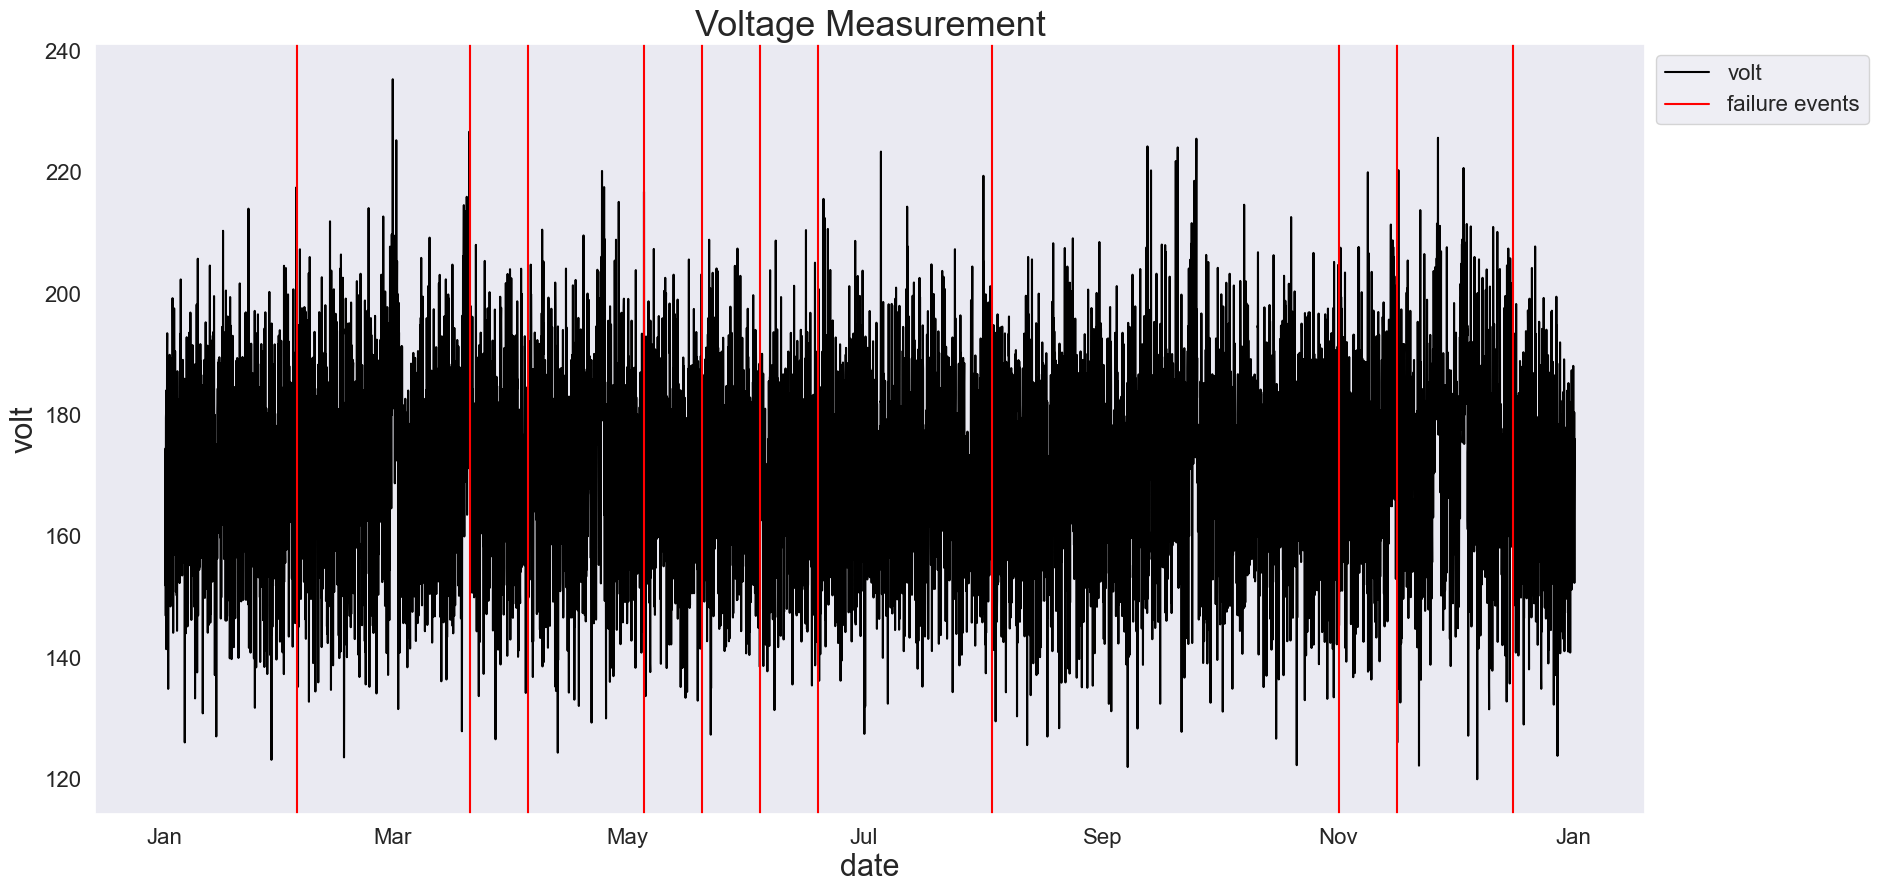

In [432]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(sen_data['datetime'], sen_data['volt'], color='black', label='volt')
ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
for dt in fail_dt['datetime'][1:]:
  ax.axvline(x=dt, color='red')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

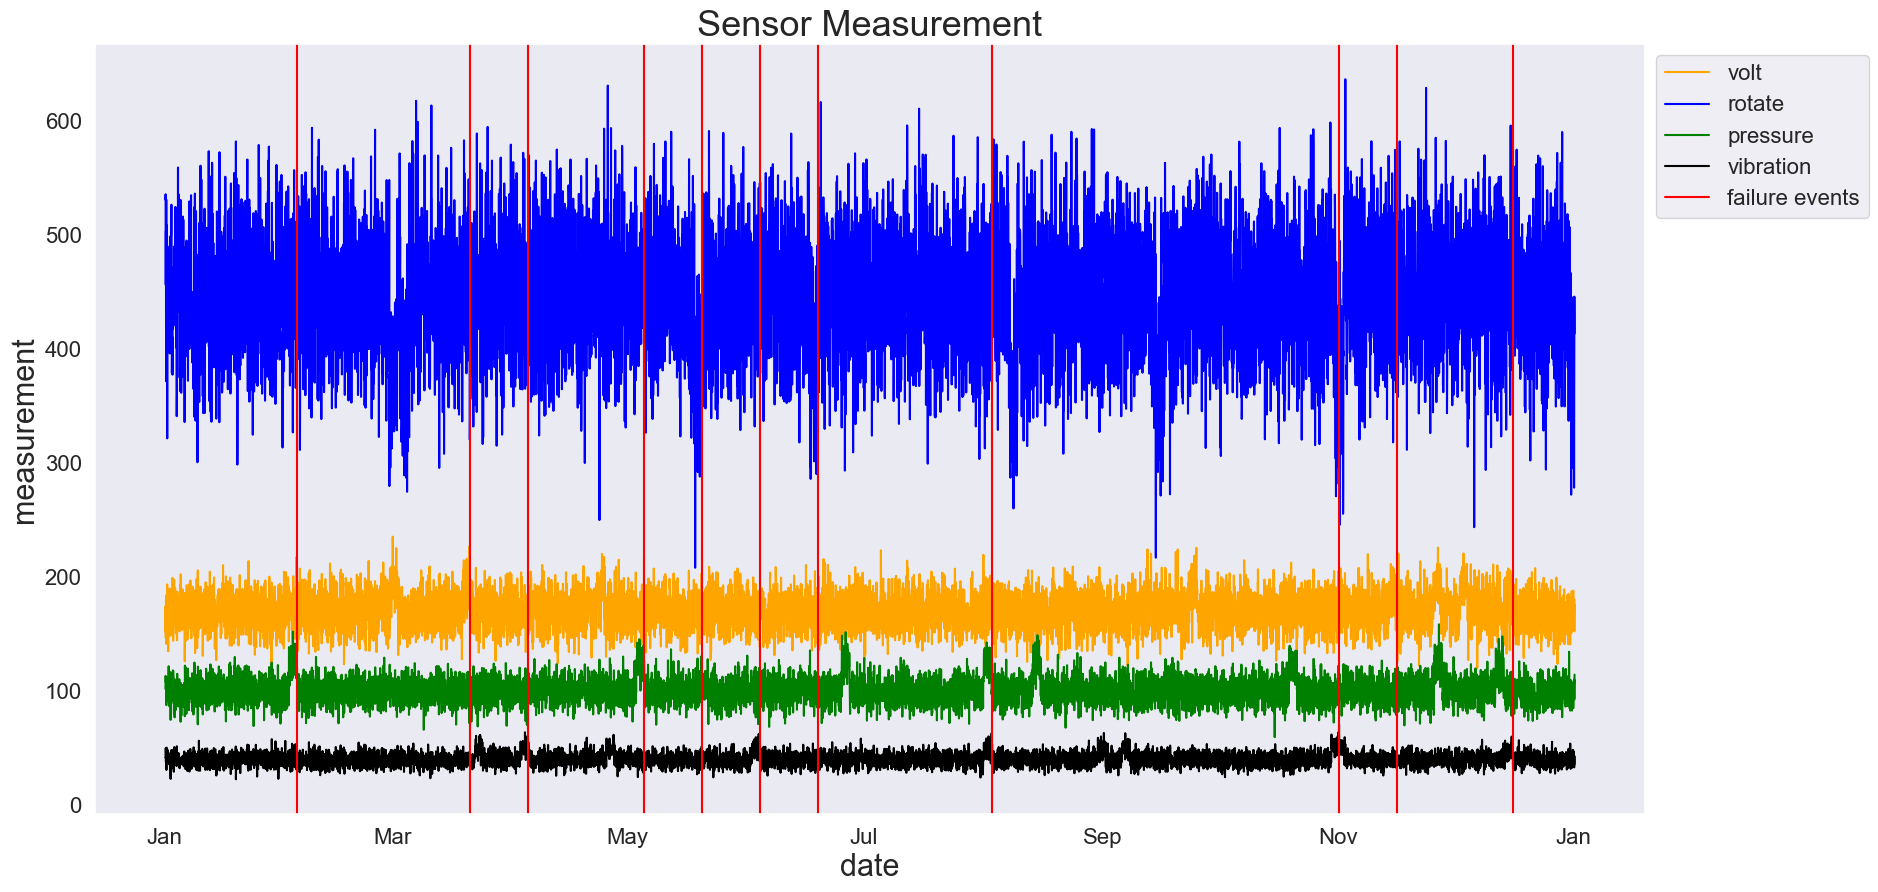

In [433]:
def plot_diagnostic_data(sen_data, fail_dt, predicted_fail_dt):
    fig, ax =  plt.subplots(figsize=(20,10))

    # Plot data
    ax.plot(sen_data['datetime'], sen_data['volt'], color='orange', label='volt')
    ax.plot(sen_data['datetime'], sen_data['rotate'], color='blue', label='rotate')
    ax.plot(sen_data['datetime'], sen_data['pressure'], color='green', label='pressure')
    ax.plot(sen_data['datetime'], sen_data['vibration'], color='black', label='vibration')

    ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
    for dt in fail_dt['datetime'][1:]:
        ax.axvline(x=dt, color='red')

    if type(predicted_fail_dt) != type(None):
        if predicted_fail_dt.empty != True:
            ax.axvline(x=predicted_fail_dt['datetime'][0], color='blue', label='predicted failure events', linestyle = '--')
            for dt in predicted_fail_dt['datetime'][1:]:
                ax.axvline(x=dt, color='blue', linestyle = '--')
        else: 
            print('\033[91m' + '\033[1m' + '-'*50 + 'EMPTY PREDICTED FAILURE DATA!' + '-'*50 + '\033[0m')

    # Format X axis - DateTime
    # date_form = DateFormatter("%m-%d")
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)

    plt.title("Sensor Measurement", fontsize = 26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("measurement", fontsize = 22)
    plt.grid()
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

plot_diagnostic_data(sen_data, fail_dt, None)

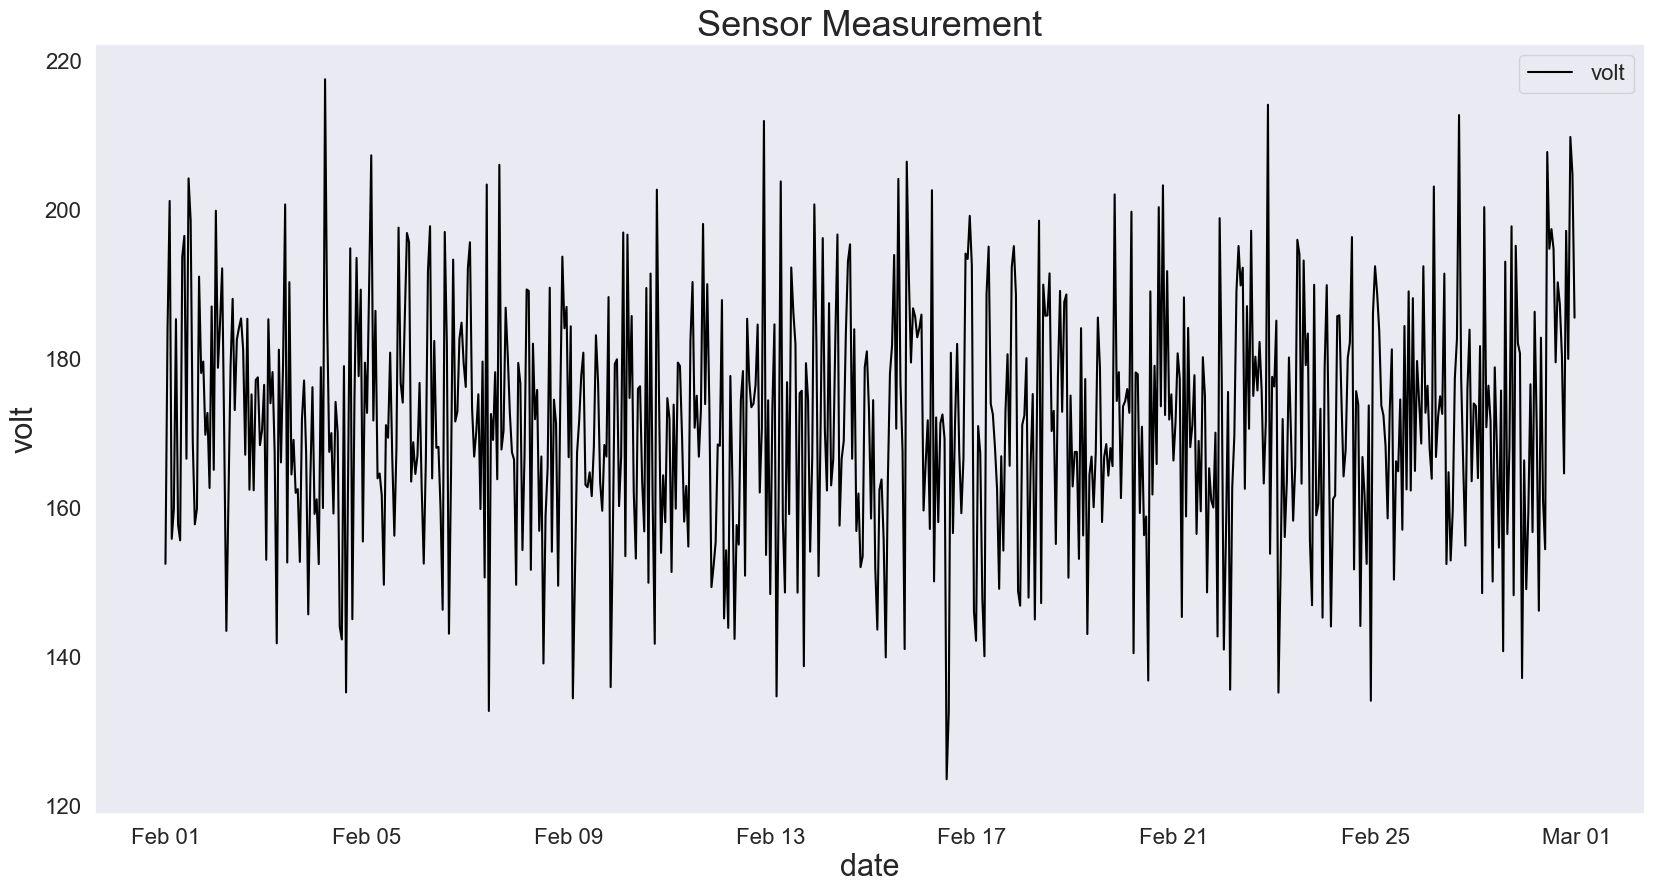

In [434]:
# Extract February data
data = sen_data[[True if data.strftime("%B") == 'February' else False for data in sen_data['datetime']]]
data = data.reset_index(drop=True)

fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)

plt.title("Sensor Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

In [435]:
win_size = 20
data = data.sort_values(by='datetime', ascending = True) # Ensure time order is preserved
data['roll_volt'] = np.nan
for i in range(len(data)-20+1):
    data.at[i+win_size-1, 'roll_volt'] = data['volt'][i:i+win_size].mean()

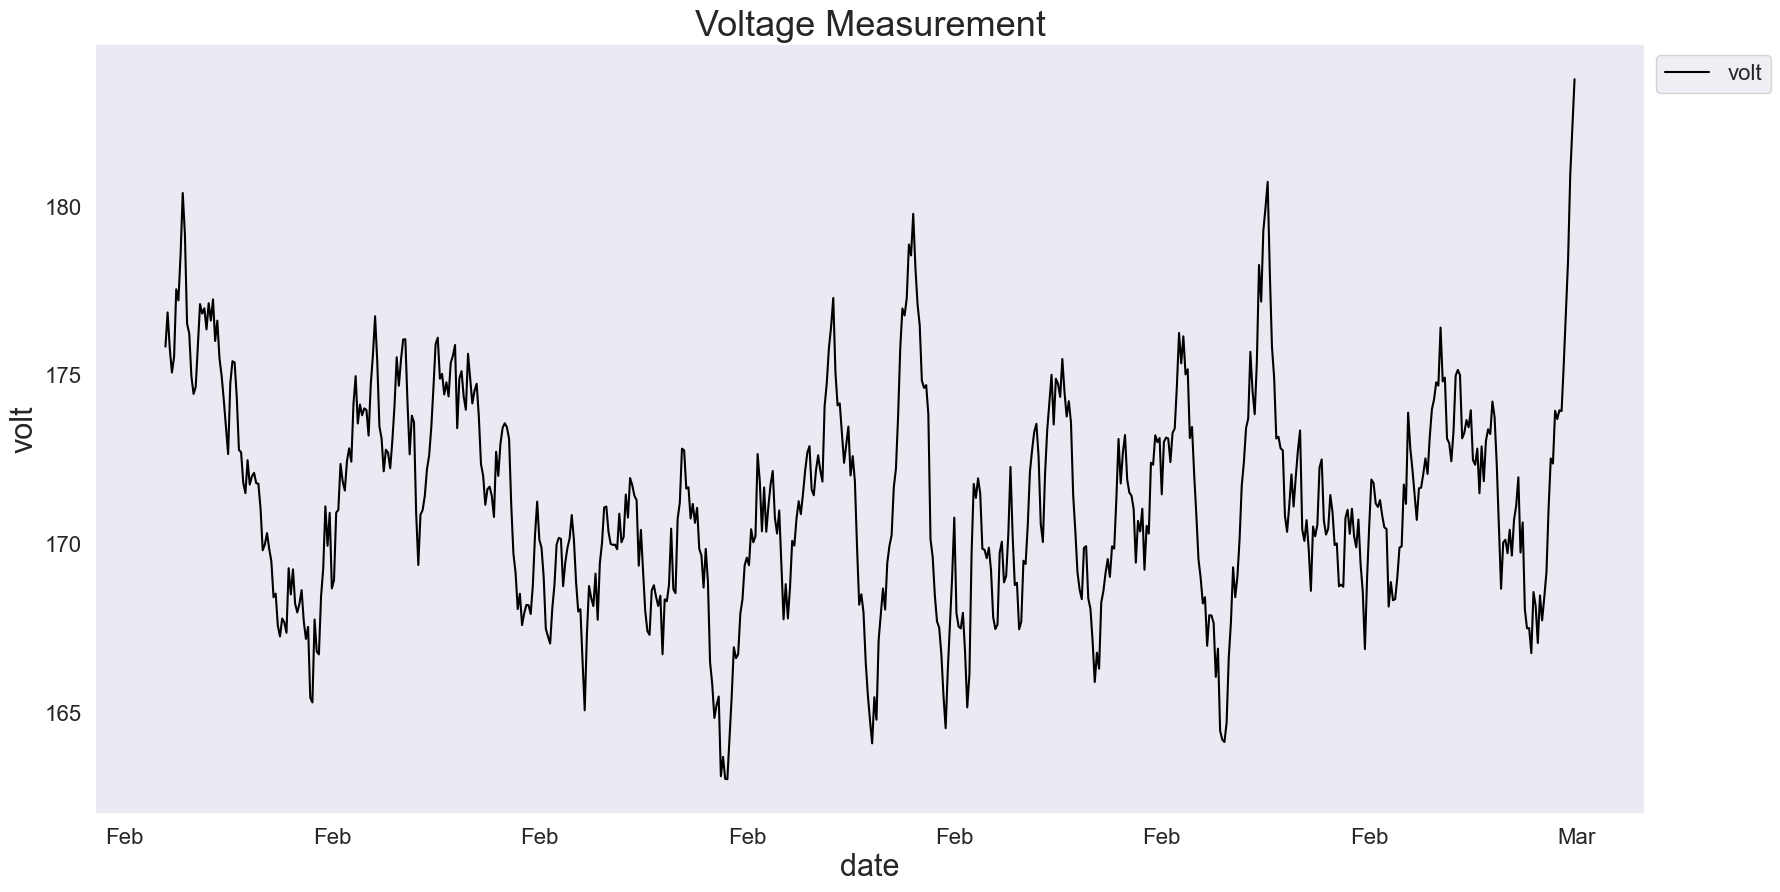

In [436]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['roll_volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

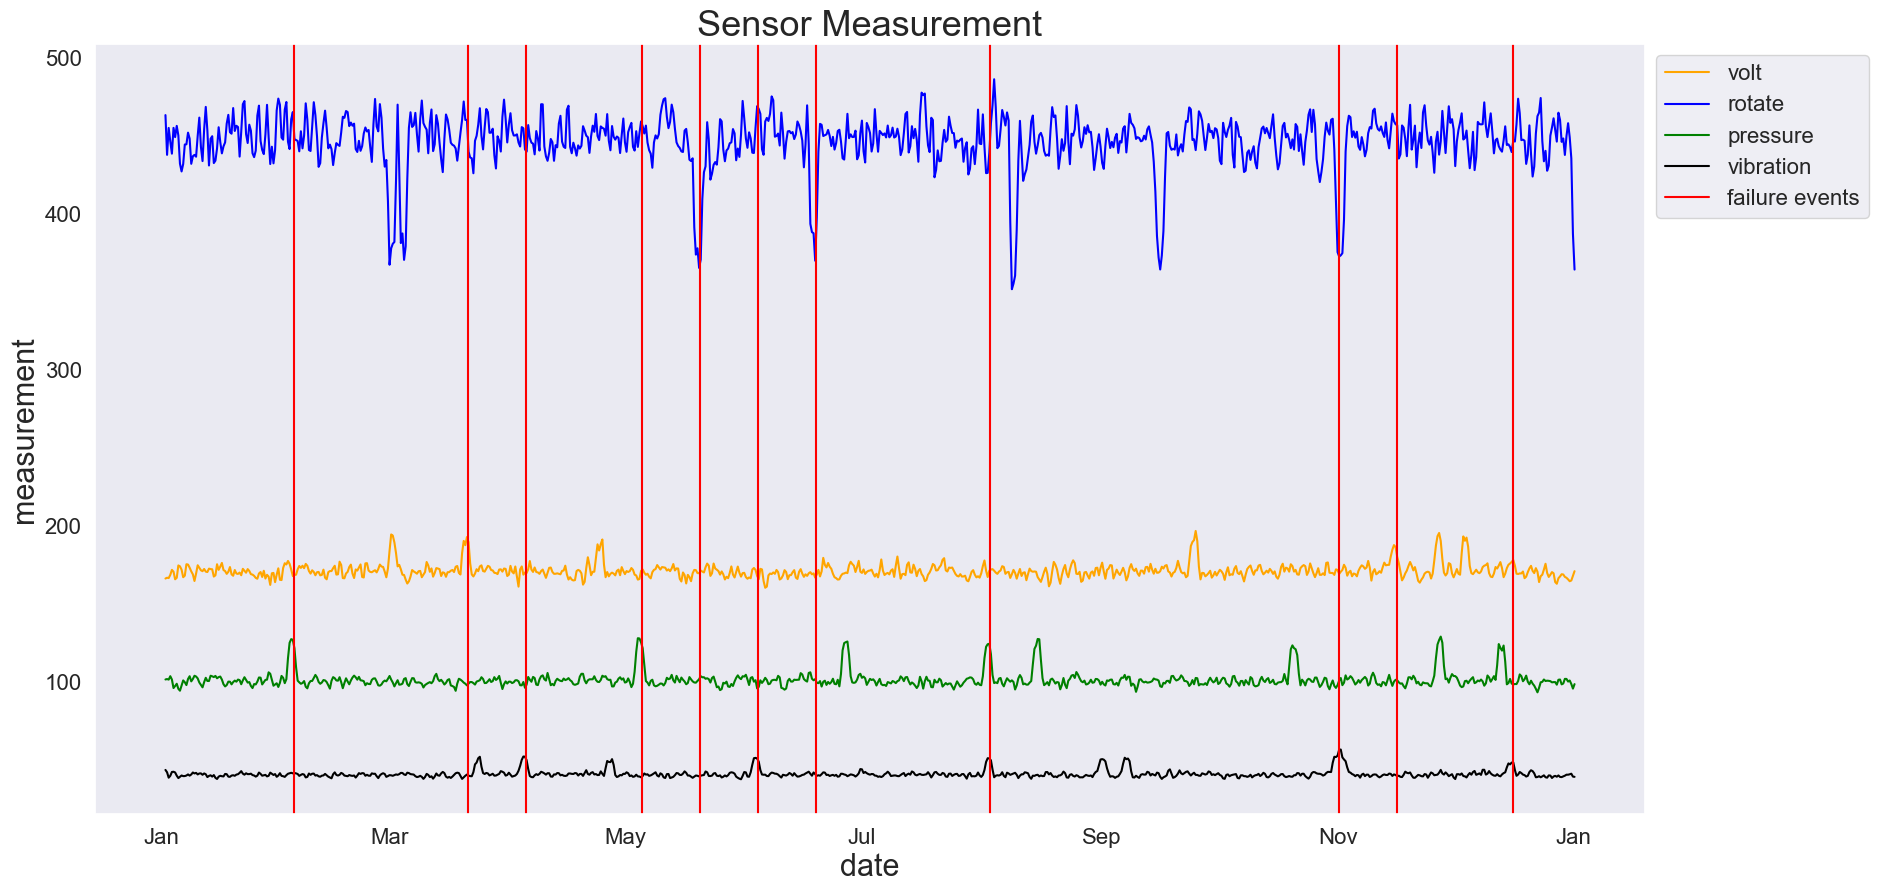

In [437]:
def sliding_mean(data, win_size, step_size=1):
    data_dict = {}
    for col_name in data.columns:
        data_dict[col_name] = []
    for col_name in data.columns:
        i = 0
        while i < (len(data)-win_size):
            if(col_name == 'datetime'):
                data_dict[col_name].append(data[col_name][i+win_size-1])
            else:   
                data_dict[col_name].append(data[col_name][i:i+win_size].mean())
            i += step_size
        
    return (pd.DataFrame(data_dict))

slide_mean_data = sliding_mean(sen_data, 20, 10)

plot_diagnostic_data(slide_mean_data, fail_dt, None)

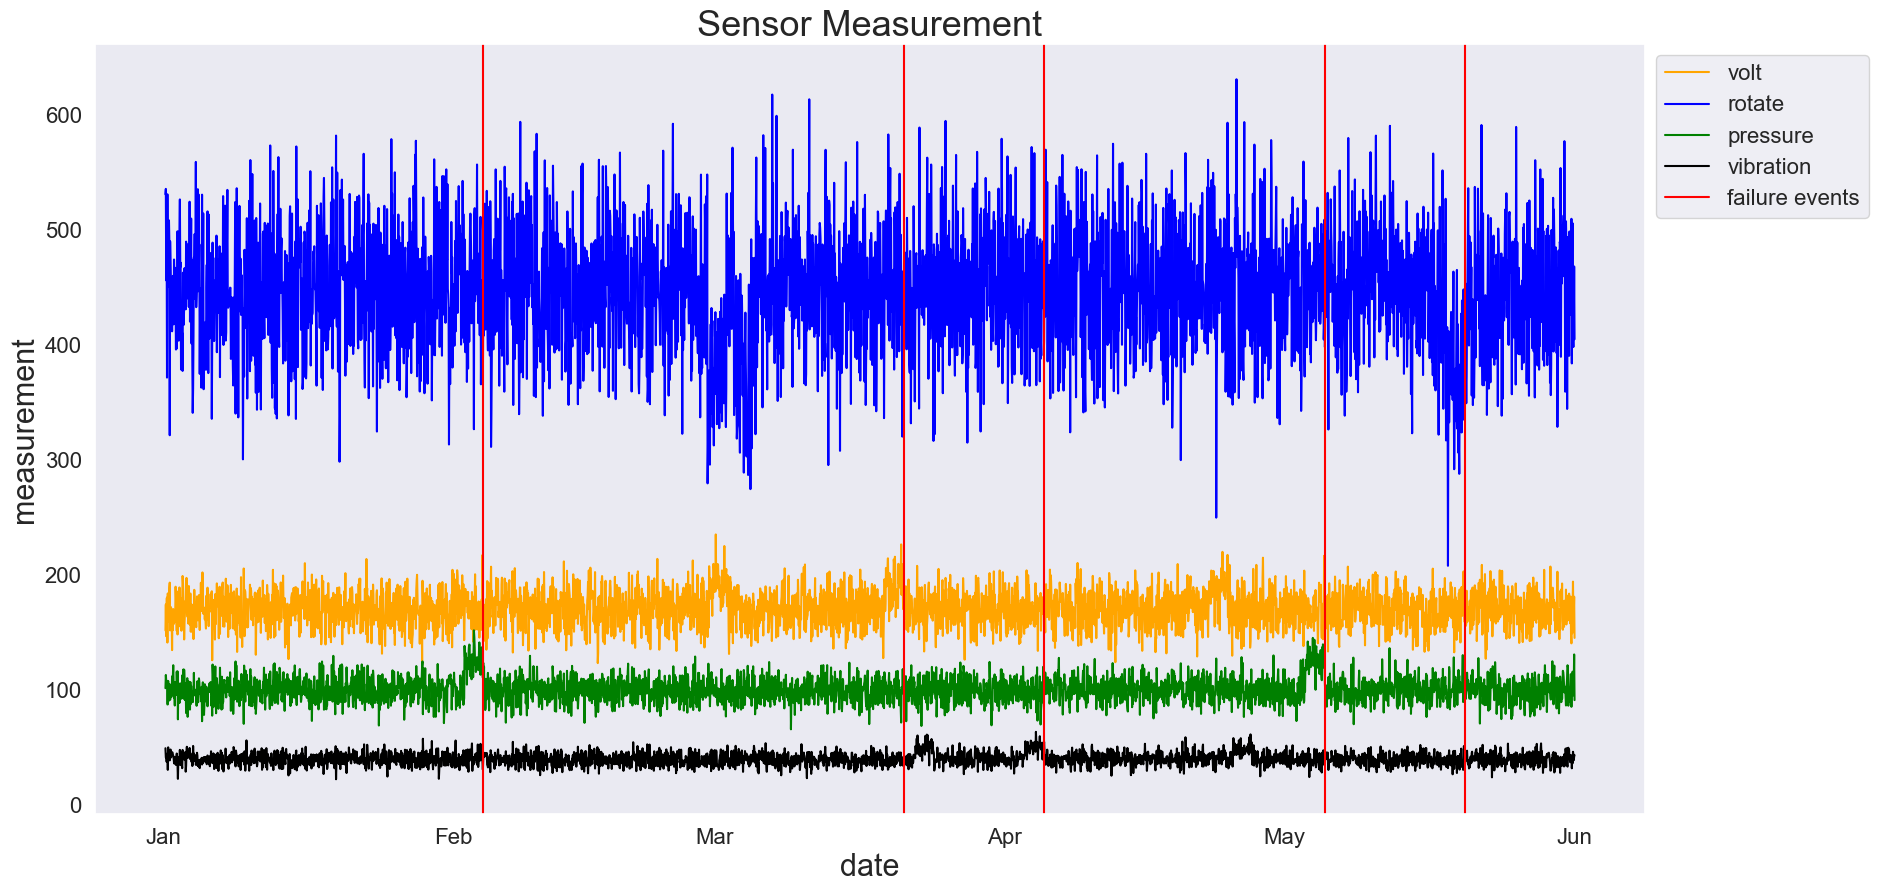

In [438]:
train_tp = pd.to_datetime("2015-06-01")
train_data = sen_data[sen_data['datetime'] <= train_tp]
train_data_fail = fail_dt[fail_dt['datetime'] <= train_tp]

plot_diagnostic_data(train_data, train_data_fail, None)


In [439]:
train_data = sliding_mean(train_data, 20, 10)

In [440]:
train_data['state'] = 'normal'
for dt in train_data_fail['datetime']:
    for i in range(len(train_data)):
        # Find time point that was just before failure event
        if(dt < train_data['datetime'][i]):
            train_data.at[i-1, 'state'] = 'failure'
            break
            
train_data['state'].value_counts()

normal     355
failure      5
Name: state, dtype: int64

In [441]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])

KNeighborsClassifier(n_neighbors=3)

In [442]:
# Using slided data

all_data = sliding_mean(sen_data, 20, 10)
knn_predict = knn_model.predict(all_data[all_data.columns.difference(['datetime', 'state'])])
knn_fail_dt = all_data[knn_predict=='failure']['datetime'].to_frame().reset_index()
knn_fail_dt

,index,datetime
0,78,2015-02-03 13:00:00
1,79,2015-02-03 23:00:00
2,423,2015-06-27 07:00:00
3,792,2015-11-28 01:00:00


In [443]:

true_state = {'datetime' : all_data['datetime'],
              'state' : ['normal']*len(all_data)}
true_state = pd.DataFrame(true_state)
for dt in fail_dt['datetime']:
    for i in range(len(true_state)):
        # Find time point that was just before failure event
        if(dt < true_state['datetime'][i]):
            true_state.at[i-1, 'state'] = 'failure'
            break

true_state = np.array(true_state['state'])

In [523]:
def classification_metrics(predicted, true):    
    cm = confusion_matrix(true, predicted, labels = ['failure', 'normal'])
    print("Confusion Matrix:")
    print("             Predicted")
    print("             failure normal")
    print("True failure       " + str(cm[0][0]) + "      " + str(cm[0][1]))
    print("      normal       " + str(cm[1][0]) + "     " + str(cm[1][1]))
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    error_rate = (FP+FN)/(TP+TN+FP+FN)
    accuracy = 1-error_rate
    
    recall = TP/(TP+FN)
    print('recall'+ str(recall))
    specificity = TN/(FP+TN)
    print('specificity'+ str(specificity))
    precision = TP/(TP+FP)
    print('precision'+ str(precision))
    F_Score = 2*precision*recall/(precision+recall)
    print('F_Score'+ str(F_Score))

    acc = accuracy_score(true, predicted)*100
    gm = np.sqrt(np.prod([cm.diagonal()/np.sum(cm, axis=1)]))*100
    print('\nWith accuracy of {0:.2f}% and GMean score of {1:.2f}%'.format(acc, gm))

    print('\n accuracy of {0:.2f}% and  \n recall: {1:.2f}%\n specificity: {1:.2f}%\n precision: {1:.2f}%\n F_Score:{1:.2f}%'.format(100*accuracy, 100*recall, 100*specificity, 100*precision, 100*F_Score))
   

# Write the code to compute Recall, Specificity, Precision and F-score in the function above
# Print out these results   

In [445]:
knn_predict

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'failure', 'failure', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'no

In [446]:
classification_metrics(knn_predict, true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       1      10
      normal       3     861

With accuracy of 98.51% and GMean score of 30.10%


Methods 2
PCA

In [447]:
X_train = train_data.set_index('datetime')  # Training data set
X_all = all_data.set_index('datetime')  # All the data set

In [448]:
X_all = X_all.reset_index()
X_all_maha = X_all

In [449]:
X_all['state'] = 'normal'
for dt in fail_dt['datetime']:
    for i in range(len(X_all)):
        # Find time point that was just before failure event
        if(dt < X_all['datetime'][i]):
            X_all.at[i-1, 'state'] = 'failure'
            break
            
X_all['state'].value_counts()

normal     864
failure     11
Name: state, dtype: int64

In [450]:
#Define PCA for training and testing dataset
# = np.array(X_train_PCA.values)
#pca_test = np.array(X_all_PCA.values)

# MahalanobisDist

In [451]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [452]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [453]:
cov_matrix, inv_cov_matrix  = cov_matrix(X_all_maha[['volt', 'rotate', 'pressure', 'vibration']])

In [454]:
#Calculate Mahalanobis distance
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff.iloc[i].dot(inv_covariance_matrix).dot(diff.iloc[i])))
    return md

In [455]:
#Calculate threshold
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [456]:
#X_train_values = X_train[['volt', 'rotate', 'pressure', 'vibration']]
X_all_values = X_all[['volt', 'rotate', 'pressure', 'vibration']]
mean = X_all[['volt', 'rotate', 'pressure', 'vibration']].mean(axis=0)

In [457]:
# Based on training data get threshold
#distance_train = MahalanobisDist(inv_cov_matrix, mean, X_train_values, verbose=False)
distance_all = MahalanobisDist(inv_cov_matrix, mean, X_all_values, verbose=False)
threshold = MD_threshold(distance_all, extreme = True)

/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_89845/3309462156.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distance_all,


Text(0.5, 0, 'Mahalanobis distance')

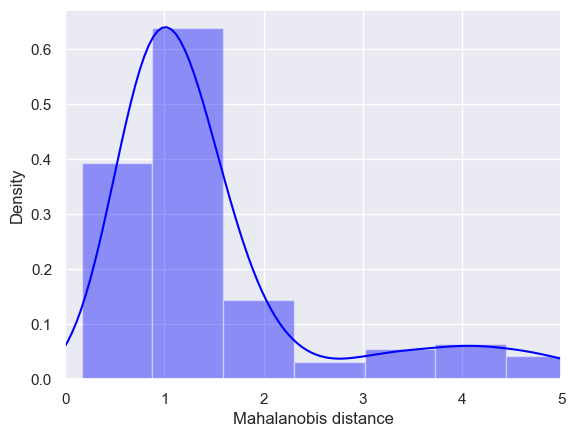

In [458]:
# View the distribution of Mahalanobis distance
plt.figure()
sns.distplot(distance_all,
             bins = 10, 
             kde= True, 
            color = 'blue');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis distance')

<function matplotlib.pyplot.show(close=None, block=None)>

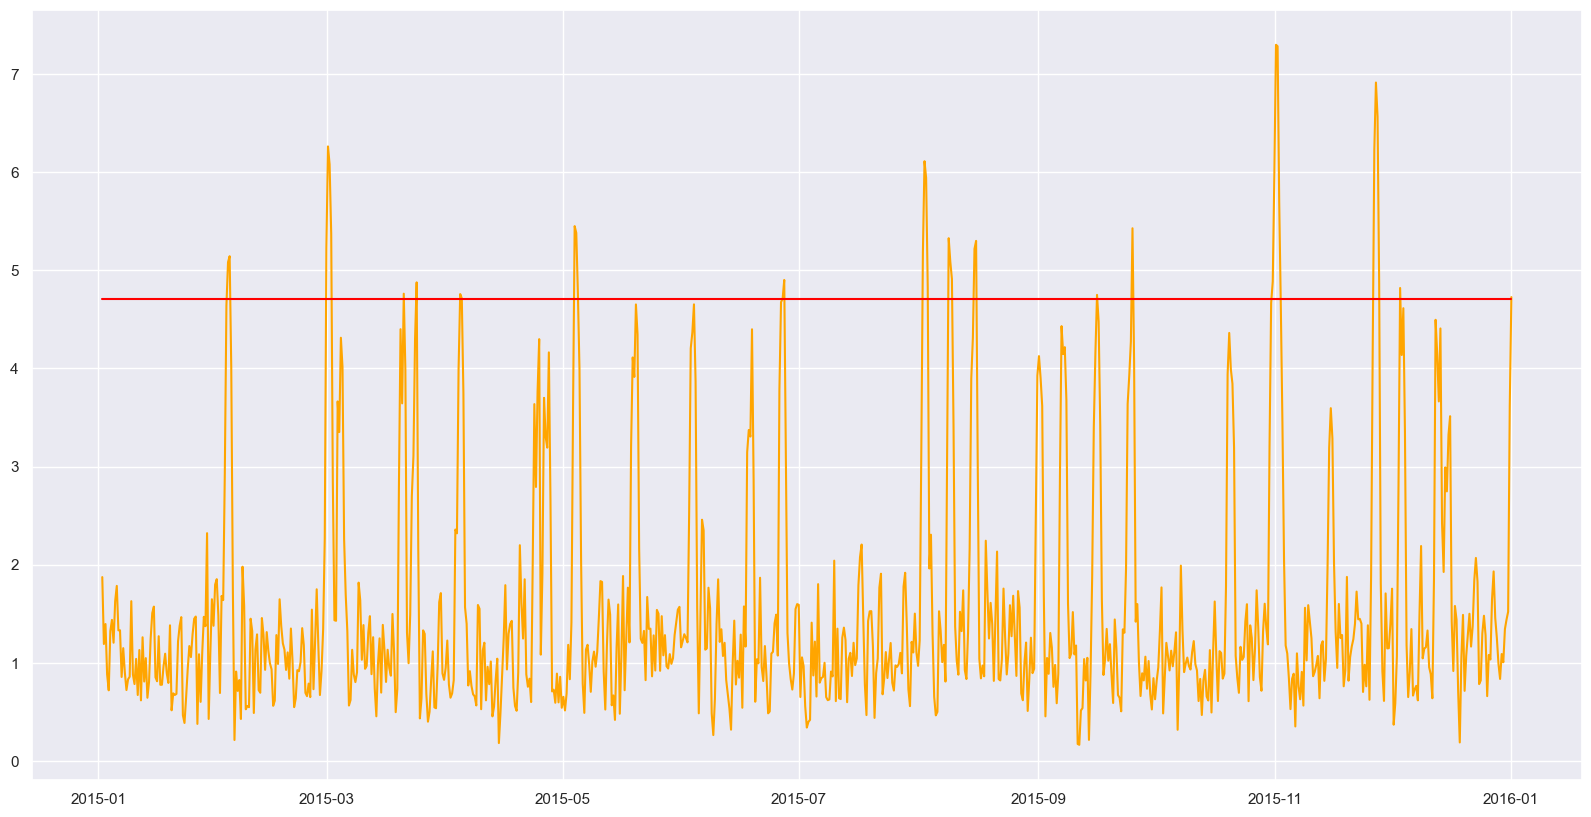

In [459]:
# Directly use all data
fig, ax =  plt.subplots(figsize=(20,10))
y = threshold*np.ones([len(all_data),1])
ax.plot(all_data['datetime'], distance_all, color='orange', label='volt')
ax.plot(all_data['datetime'], y, color='red', label='rotate')
plt.show

In [460]:
maha_state = pd.DataFrame()
maha_state['datetime'] = X_all_maha['datetime']
maha_state['state'] = 'normal'

In [461]:
#pca_state

In [462]:
# Combine the continous error into one error
X_all_maha['Maha_dis']  = distance_all
for i in range(len(distance_all)):
    t = 0
    while  distance_all[i+t] > threshold:
        distance_all[i+t] = threshold-1
        maha_state['state'].iloc[i+t] = 'normal'
        if i+t+1 < len(distance_all):
            t += 1
    if t > 0:
        distance_all[i + round(t/2)] = threshold+1
        maha_state['state'].iloc[i+round(t/2)] = 'failure'
     
distance_all>threshold

/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_89845/1911904777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maha_state['state'].iloc[i+t] = 'normal'
/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_89845/1911904777.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maha_state['state'].iloc[i+round(t/2)] = 'failure'


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [463]:
fail_maha = pd.DataFrame()
fail_maha['datetime'] = pd.to_datetime(maha_state[maha_state['state']=='failure']['datetime'])  #fail_dt[fail_dt['datetime'] <= train_tp]
fail_maha = fail_maha.reset_index(drop=True)

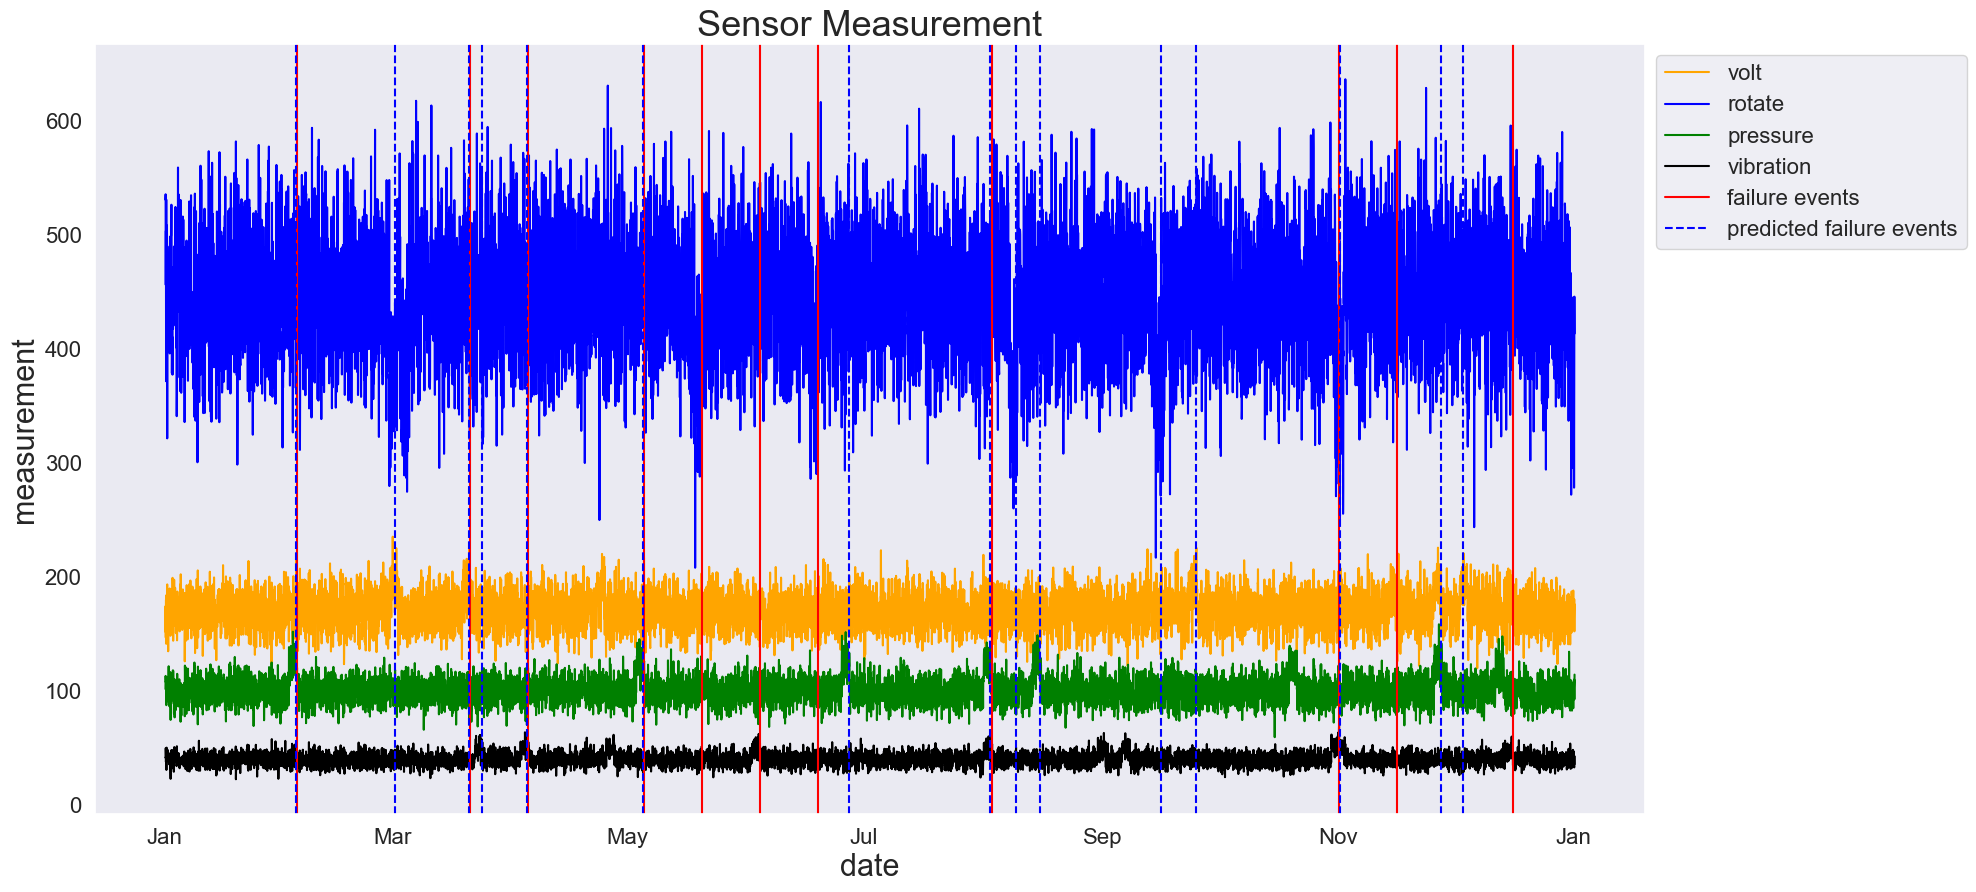

In [464]:
plot_diagnostic_data(sen_data, fail_dt, fail_maha)

In [465]:
maha_state['state'].value_counts()

normal     860
failure     15
Name: state, dtype: int64

In [524]:
maha_state['datetime'] = pd.to_datetime(maha_state['datetime'])
classification_metrics(maha_state['state'], true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       5      6
      normal       10     854
recall0.3333333333333333
specificity0.9930232558139535
precision0.45454545454545453
F_Score0.3846153846153846

With accuracy of 98.17% and GMean score of 67.03%

 accuracy of 98.17% and  
 recall: 33.33%
 specificity: 33.33%
 precision: 33.33%
 F_Score:33.33%


PCA
X_train = X_train[['volt', 'rotate', 'pressure', 'vibration']]
X_all = X_all[['volt', 'rotate', 'pressure', 'vibration']]

# PCA

In [467]:
from sklearn.decomposition import PCA # Build the PCA model
PCA = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = PCA.fit_transform(X_train[['volt', 'rotate', 'pressure', 'vibration']])
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_all_PCA = PCA.transform(X_all[['volt', 'rotate', 'pressure', 'vibration']])
X_all_PCA = pd.DataFrame(X_all_PCA)
X_all_PCA.index = X_all.index

X_train


,volt,rotate,pressure,vibration,state
datetime,,,,,
2015-01-02 01:00:00,165.986300,463.146618,101.252537,43.257060,normal
2015-01-02 11:00:00,166.481762,437.660900,101.532750,41.730663,normal
2015-01-02 21:00:00,166.287348,454.921207,101.167522,38.284306,normal
2015-01-03 07:00:00,168.322989,446.274223,103.356567,39.485176,normal
2015-01-03 17:00:00,171.531552,438.418174,101.218941,41.933467,normal
...,...,...,...,...,...
2015-05-29 23:00:00,173.652890,441.694405,103.889893,38.212154,normal
2015-05-30 09:00:00,169.655455,436.350620,102.308495,37.640583,normal
2015-05-30 19:00:00,167.203435,450.709471,101.471011,37.278153,normal


In [468]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
X = X_all[['volt', 'rotate', 'pressure', 'vibration']].values
X_all['Maha_dis']  = distance_all
y = X_all["state"].values
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y).T
#print(y)

target_names = le.classes_
print(target_names)


['failure' 'normal']


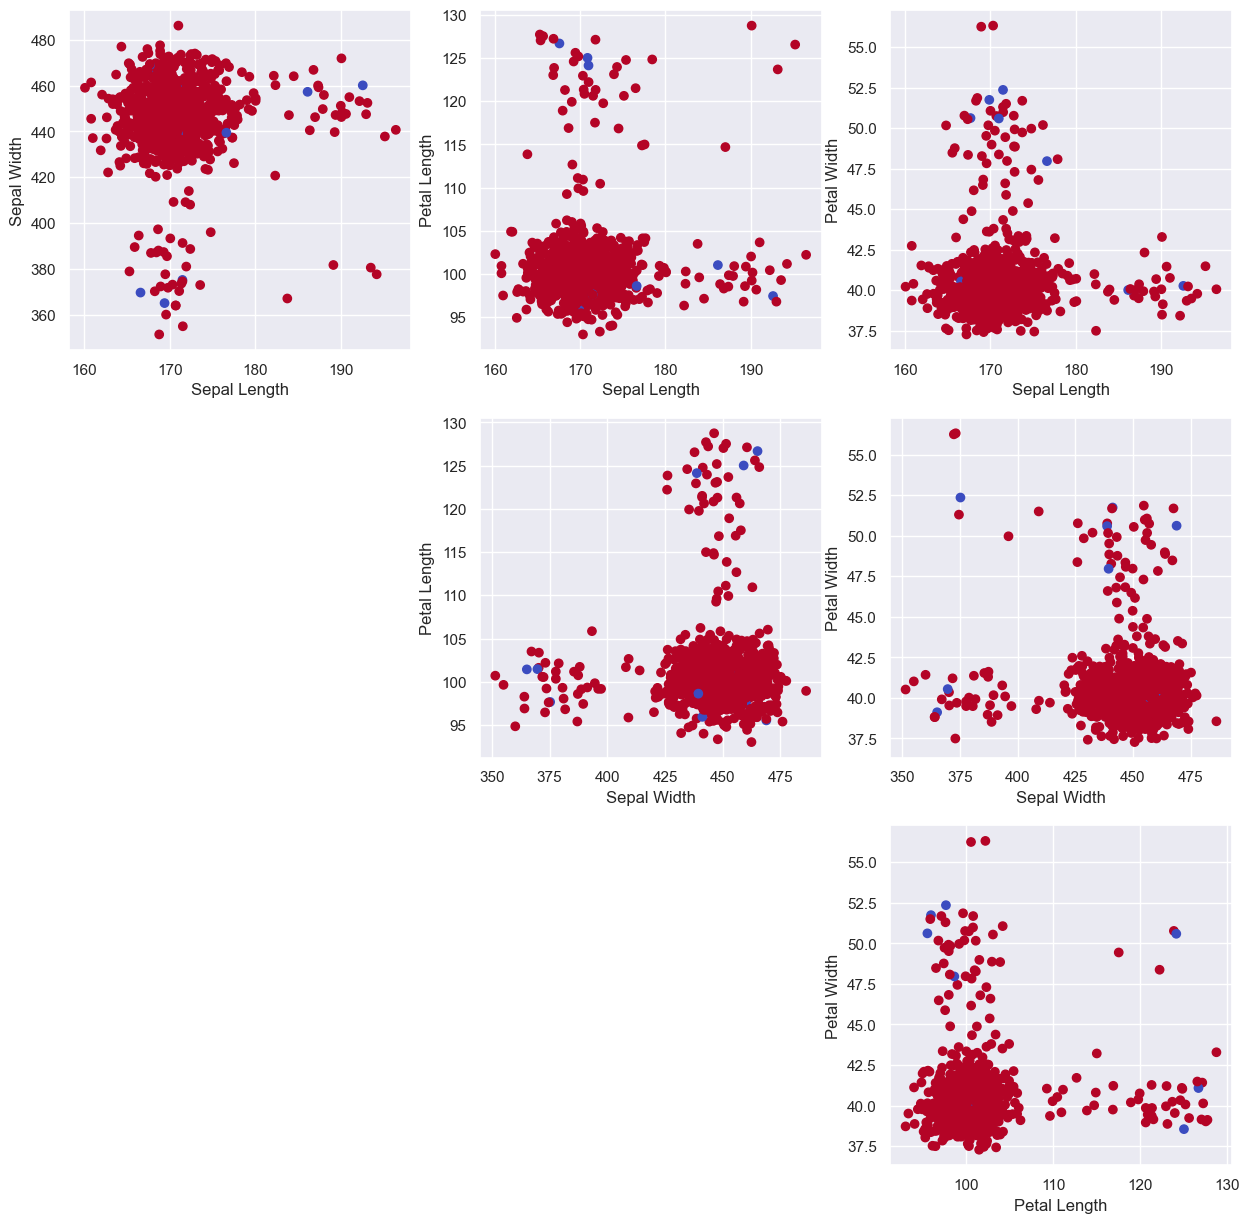

In [469]:
# # View the anomaly distribution between different factors
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.scatter(X_all["volt"], X_all["rotate"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')

plt.subplot(332)
plt.scatter(X_all["volt"], X_all["pressure"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Length')

plt.subplot(333)
plt.scatter(X_all["volt"], X_all["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Width')

plt.subplot(335)
plt.scatter(X_all["rotate"], X_all["pressure"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Width'); plt.ylabel('Petal Length')

plt.subplot(336)
plt.scatter(X_all["rotate"], X_all["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Width'); plt.ylabel('Petal Width')

plt.subplot(339)
plt.scatter(X_all["pressure"], X_all["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Petal Length'); plt.ylabel('Petal Width')

plt.show()

Text(0, 0.5, 'Petal Width')

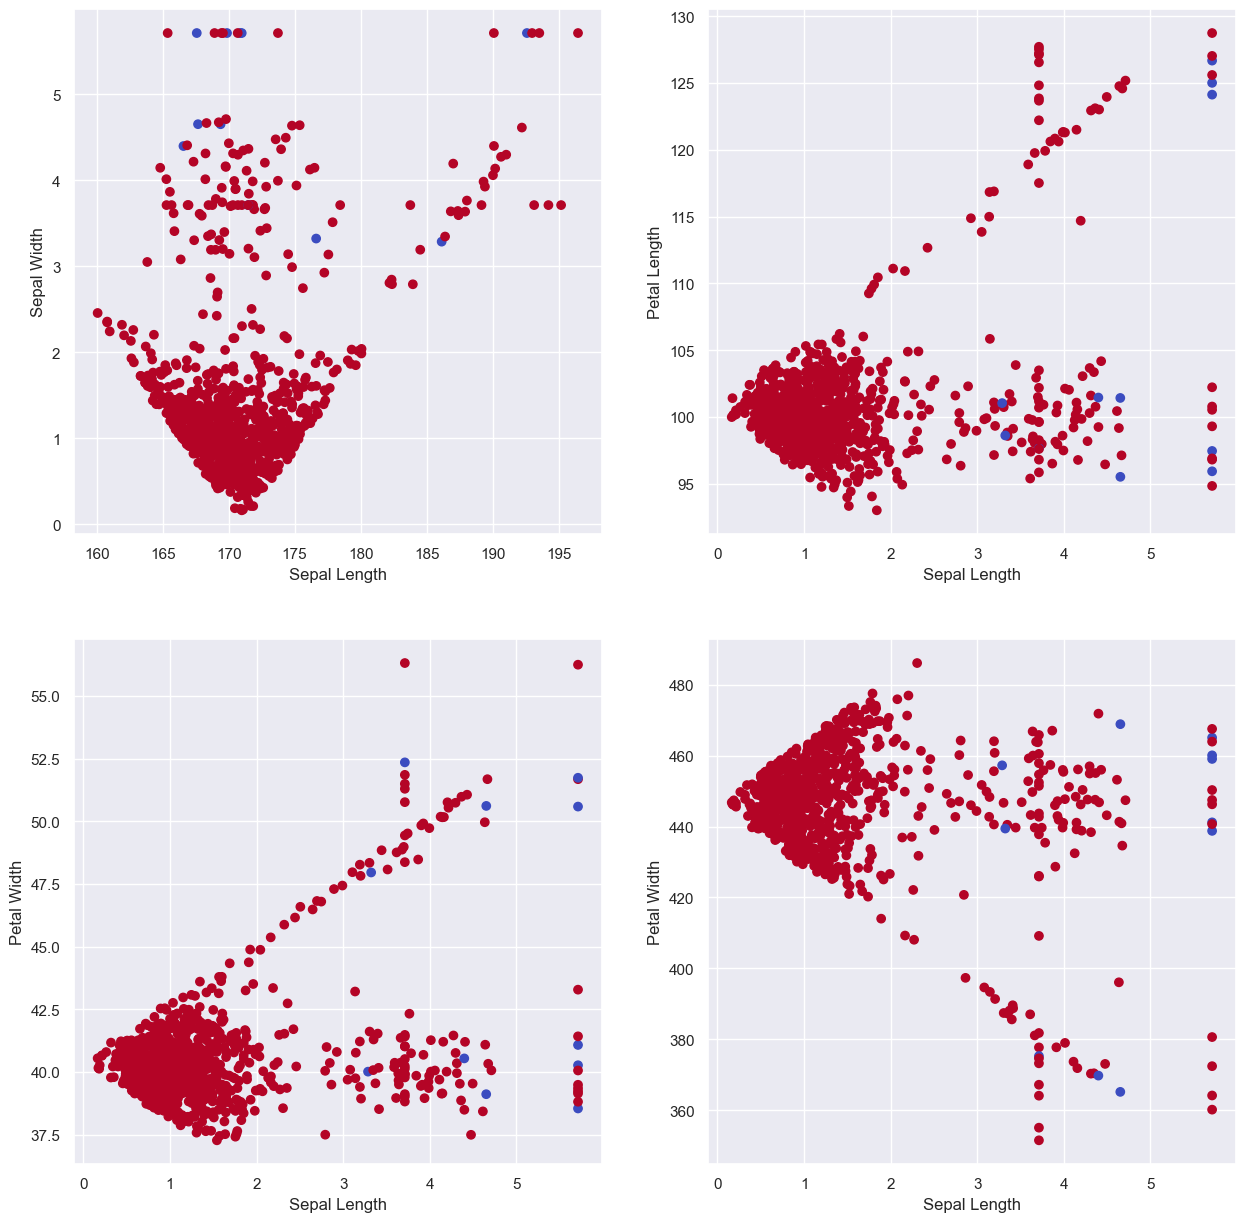

In [470]:
# View the anomaly distribution between different factors with "Maha_dis"
plt.figure(figsize=(15,15))

plt.subplot(221)
plt.scatter(X_all_maha["volt"], X_all_maha["Maha_dis"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Sepal Width')

plt.subplot(222)
plt.scatter(X_all_maha["Maha_dis"], X_all_maha["pressure"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Length')

plt.subplot(223)
plt.scatter(X_all_maha["Maha_dis"], X_all_maha["vibration"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Width')

plt.subplot(224)
plt.scatter(X_all_maha["Maha_dis"], X_all_maha["rotate"], c = y, cmap='coolwarm')
plt.xlabel('Sepal Length'); plt.ylabel('Petal Width')


In [471]:
Y_train_predict = pd.DataFrame()
Y_train_predict['state'] = X_train['state']
Y_train_predict = Y_train_predict.reset_index()
Y_train_predict

,datetime,state
0,2015-01-02 01:00:00,normal
1,2015-01-02 11:00:00,normal
2,2015-01-02 21:00:00,normal
3,2015-01-03 07:00:00,normal
4,2015-01-03 17:00:00,normal
...,...,...
355,2015-05-29 23:00:00,normal
356,2015-05-30 09:00:00,normal
357,2015-05-30 19:00:00,normal
358,2015-05-31 05:00:00,normal


In [472]:
X = X_all[['volt', 'rotate', 'pressure', 'vibration']].values

Y = X_all["state"].values
le = preprocessing.LabelEncoder()
le.fit(y)
Y = le.transform(y).T
#print(y)

target_names = le.classes_
print(target_names)

[0 1]


In [473]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print("Principal Component Analysis: ")
print("Explained variance ratio (first two components): " + str(pca.explained_variance_ratio_))
print("These two components cover " + str(round(100*sum(pca.explained_variance_ratio_) ,2)) + "% of the variance")

Principal Component Analysis: 
Explained variance ratio (first two components): [0.85378823 0.07335059]
These two components cover 92.71% of the variance


Text(0.5, 1.0, 'PCA of IRIS dataset')

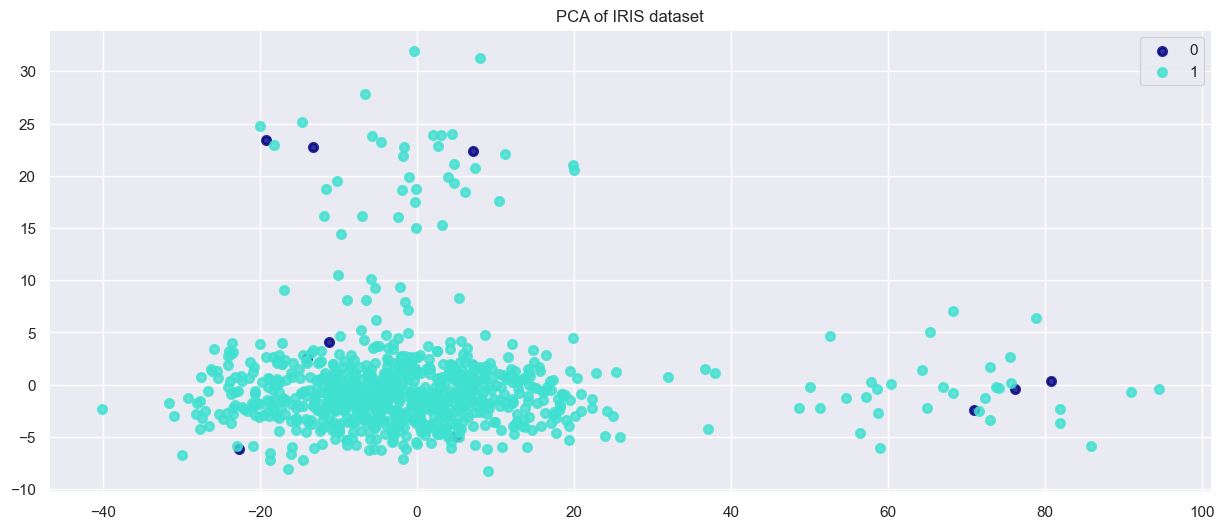

In [501]:
plt.figure(figsize=(15,6))

colors = ['navy', 'turquoise']
lw = 2

#plt.subplot(121)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[Y  == i, 0], X_r[Y  == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

#for  i in range(len(Y)):
#    if Y[i] == 1:
#        Y_train_predict['state'].iloc[i] = 'normal'
#    else:
#        Y_train_predict['state'].iloc[i] = 'fail'

#plt.subplot(122)
#for color, i, target_name in zip(colors, [0, 1], target_names):
#    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
#                label=target_name)
#plt.legend(loc='best', shadow=False, scatterpoints=1)
#plt.title('LDA of IRIS dataset')

#plt.show()

In [502]:
XX = X_all[['volt', 'rotate', 'pressure', 'vibration','Maha_dis']].values
yy = true_state
res_all = pca.fit(XX).transform(XX)

pca = PCA(n_components=2)
XX_r = pca.fit(XX).transform(XX)

Text(0.5, 1.0, 'PCA components = 2')

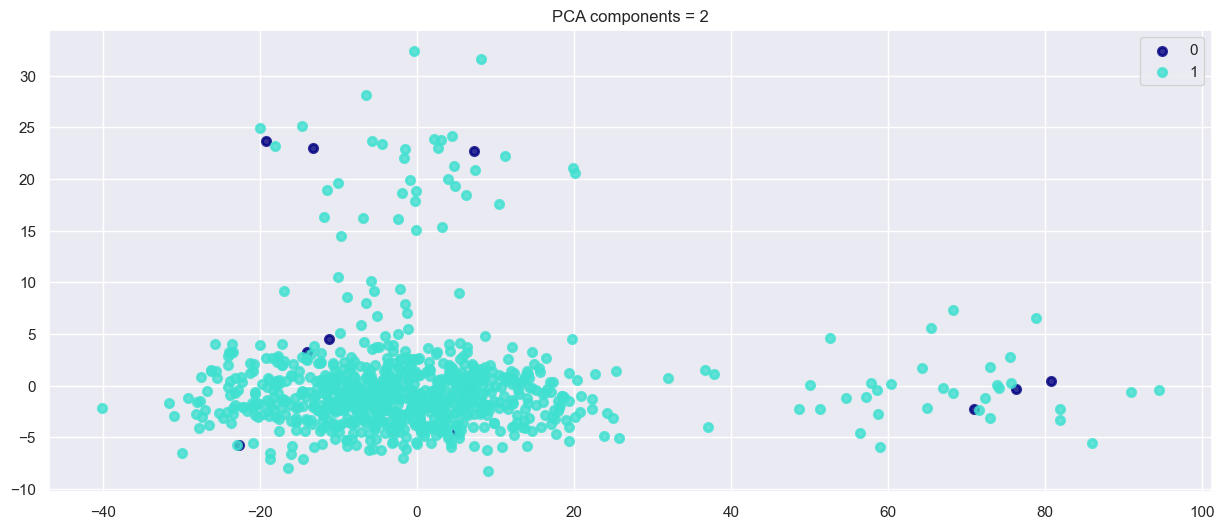

In [503]:
plt.figure(figsize=(15,6))

colors = ['navy', 'turquoise']
lw = 2

#plt.subplot(121)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(XX_r[Y  == i, 0], XX_r[Y  == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA components = 2')

In [504]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly Choose Clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a assign labels  based on closest center
        labels = pairwise_distances_argmin(X,centers)
        
        # 2b find new centers from mean of the points
        new_centers = np.array([X[labels == i].mean(0) for i in range (n_clusters)])
        
        # 2c Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

In [505]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(res_all)
y_kmeans = kmeans.predict(res_all)

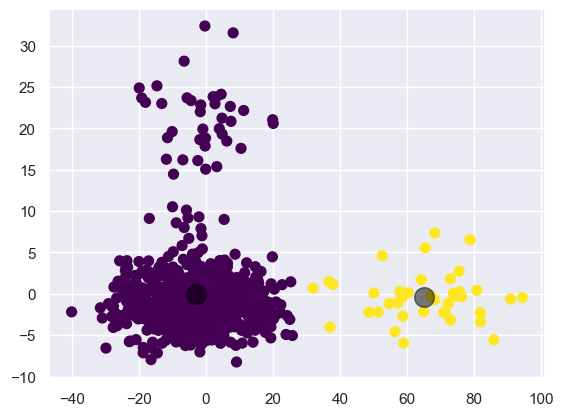

In [506]:
centers, labels = find_clusters(res_all,2)

plt.scatter(res_all[:,0], res_all[:,1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [507]:
y_kmeans

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [508]:
# Combine the continous error into one error

for i in range(len(y_kmeans)):
    t = 0
    while  y_kmeans[i+t] == 1 and i+t < len(y_kmeans):
        y_kmeans[i+t] = 0
        if t+i+1<len(y_kmeans):
            t += 1
    if t > 0:
        y_kmeans[i + round(t/2)] = 1
y_kmeans


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

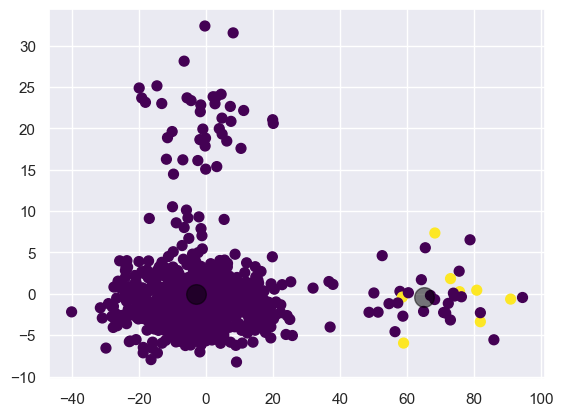

In [509]:
#centers, labels = find_clusters(res_all,2)

plt.scatter(res_all[:,0], res_all[:,1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [483]:
fail_Km = pd.DataFrame()
fail_Km['datetime'] = pd.to_datetime(maha_state[y_kmeans == 1]['datetime'])  #fail_dt[fail_dt['datetime'] <= train_tp]
fail_Km = fail_Km.reset_index(drop=True)

In [484]:
fail_Km

,datetime
0,2015-01-30 19:00:00
1,2015-03-03 11:00:00
2,2015-04-11 15:00:00
3,2015-06-03 23:00:00
4,2015-07-14 19:00:00
5,2015-08-27 23:00:00
6,2015-10-09 11:00:00
7,2015-12-02 05:00:00


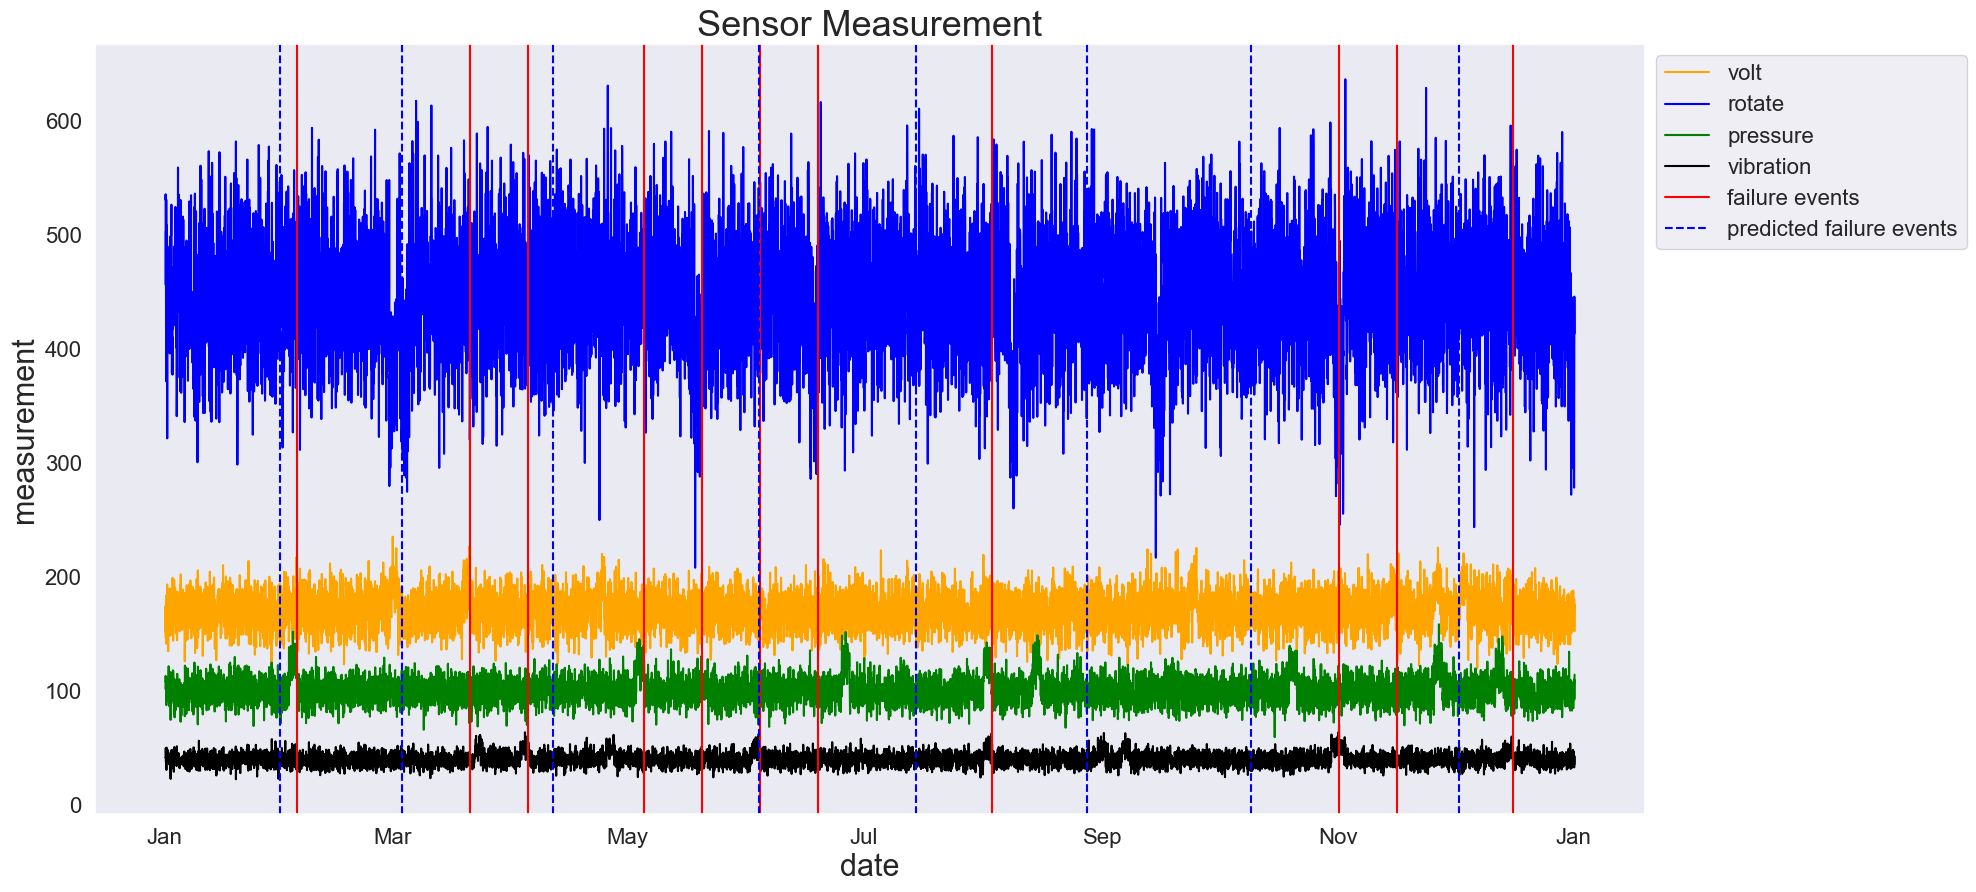

In [485]:
plot_diagnostic_data(sen_data, fail_dt, fail_Km) 

In [486]:
all_data.shape

(875, 5)

In [487]:
(true_state)

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'failure', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'nor

In [491]:
Km_state = pd.DataFrame()
Km_state['datetime'] = all_data['datetime']
Km_state['state'] = 'normal'
for i in range(len(y_kmeans)):
    if y_kmeans[i] == 1:
        Km_state['state'].iloc[i] = 'failure'



/var/folders/vw/f8nhkr8d497gmh8ytfr1p9jr0000gn/T/ipykernel_89845/3125344739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Km_state['state'].iloc[i] = 'failure'


In [525]:
classification_metrics(Km_state['state'], true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       1      10
      normal       7     857
recall0.125
specificity0.9884659746251442
precision0.09090909090909091
F_Score0.10526315789473685

With accuracy of 98.06% and GMean score of 30.03%

 accuracy of 98.06% and  
 recall: 12.50%
 specificity: 12.50%
 precision: 12.50%
 F_Score:12.50%


测试所有数据